In [ ]:
!pip install pyspark

!pip install praw

### Task 1.2

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd

Read in our data from the CSV file containing the comments of the AskUK and AskAnAmerican subreddits, that were collected over 24 hours and their associated information.

In [2]:
spark = SparkSession.builder.appName('RedditAPIAnalytics').getOrCreate()

In [3]:
#data = spark.read.option("header", "true").csv("data.csv")
data = spark.read.option("header", "true").csv("reddit_data.csv")

In [4]:
data = data.withColumn("created_utc", from_unixtime(data["created_utc"]))
data = data.withColumn("collected_utc", from_unixtime(data["collected_utc"]))

In [5]:
data.show(10)

+--------------------+-------+----------+--------------------+-------------+-------------------+-------------------+
|              author|     id|submission|                body|    subreddit|        created_utc|      collected_utc|
+--------------------+-------+----------+--------------------+-------------+-------------------+-------------------+
|         timmytucker|iz1hdlu|    zcn3kx|Hes definitely do...|AskAnAmerican|2022-12-05 20:47:30|2022-12-05 20:47:42|
|        Filmfan-2022|iz1he2y|    zdg89s|I using my phone ...|        AskUK|2022-12-05 20:47:35|2022-12-05 20:47:47|
|            Doris28a|iz1hekf|    zdeeii|Liverpool I am to...|        AskUK|2022-12-05 20:47:40|2022-12-05 20:47:52|
|Significant-Tank-883|iz1henl|    zddrfa|            Mmmmmmm…|        AskUK|2022-12-05 20:47:41|2022-12-05 20:47:52|
|   TheHalloumiCheese|iz1hftz|    zddrfa|    Elizabeth Hurley|        AskUK|2022-12-05 20:47:53|2022-12-05 20:48:10|
|          NetLegends|iz1hg3y|    zdexx6|This 100 When my ...|  

Split our dataset into two datasets, one for the AskUk subreddit and one for the AskAnAmerican subreddit.

In [6]:
UK_data = data.where("subreddit = 'AskUK'")
US_data = data.where("subreddit = 'AskAnAmerican'")

In [7]:
UK_data.show(5)

+--------------------+-------+----------+--------------------+---------+-------------------+-------------------+
|              author|     id|submission|                body|subreddit|        created_utc|      collected_utc|
+--------------------+-------+----------+--------------------+---------+-------------------+-------------------+
|        Filmfan-2022|iz1he2y|    zdg89s|I using my phone ...|    AskUK|2022-12-05 20:47:35|2022-12-05 20:47:47|
|            Doris28a|iz1hekf|    zdeeii|Liverpool I am to...|    AskUK|2022-12-05 20:47:40|2022-12-05 20:47:52|
|Significant-Tank-883|iz1henl|    zddrfa|            Mmmmmmm…|    AskUK|2022-12-05 20:47:41|2022-12-05 20:47:52|
|   TheHalloumiCheese|iz1hftz|    zddrfa|    Elizabeth Hurley|    AskUK|2022-12-05 20:47:53|2022-12-05 20:48:10|
|          NetLegends|iz1hg3y|    zdexx6|This 100 When my ...|    AskUK|2022-12-05 20:47:57|2022-12-05 20:48:10|
+--------------------+-------+----------+--------------------+---------+-------------------+----

In [8]:
US_data.show(5)

+--------------+-------+----------+--------------------+-------------+-------------------+-------------------+
|        author|     id|submission|                body|    subreddit|        created_utc|      collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------------+-------------------+
|   timmytucker|iz1hdlu|    zcn3kx|Hes definitely do...|AskAnAmerican|2022-12-05 20:47:30|2022-12-05 20:47:42|
|      trash332|iz1hheb|    zd0sxl|Nope it would tak...|AskAnAmerican|2022-12-05 20:48:10|2022-12-05 20:48:21|
|NopetyNopeNoNo|iz1hi89|    zd9opc|Hello am Canadian...|AskAnAmerican|2022-12-05 20:48:19|2022-12-05 20:48:30|
|  jamughal1987|iz1hks4|    zd81sk|       CUNY Graduate|AskAnAmerican|2022-12-05 20:48:47|2022-12-05 20:48:57|
|  shamalonight|iz1hmmo|    zcn3kx|Addressing the fi...|AskAnAmerican|2022-12-05 20:49:06|2022-12-05 20:49:17|
+--------------+-------+----------+--------------------+-------------+-------------------+-------------------+
o

#### Number of unique users in each subreddit 

##### i) Using a tumbling window

For both datasets, create our tumbling window objects of length 20 minutes and then obtain the number of unique users for each window.

In [9]:
UK_w0_tumb = window('created_utc', "20 minute")
UK_cusers_tumb = UK_data.groupBy(UK_w0_tumb).agg(countDistinct('author')).sort('window').toPandas()

In [10]:
US_w0_tumb = window('created_utc', "20 minute")
US_cusers_tumb = US_data.groupBy(US_w0_tumb).agg(countDistinct('author')).sort('window').toPandas()

In [11]:
UK_cusers_tumb['time'] = UK_cusers_tumb['window'].apply(lambda row: row[0])
UK_cusers_tumb.rename(columns={'count(author)':'count'},inplace=True)

Our AskUk subreddit unique users counts and the corresponding windows. The time column represents the start time of the window.

In [12]:
UK_cusers_tumb.head()

,window,count,time
0,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",135,2022-12-05 20:40:00
1,"(2022-12-05 21:00:00, 2022-12-05 21:20:00)",223,2022-12-05 21:00:00
2,"(2022-12-05 21:20:00, 2022-12-05 21:40:00)",231,2022-12-05 21:20:00
3,"(2022-12-05 21:40:00, 2022-12-05 22:00:00)",242,2022-12-05 21:40:00
4,"(2022-12-05 22:00:00, 2022-12-05 22:20:00)",231,2022-12-05 22:00:00


In [13]:
US_cusers_tumb['time'] = US_cusers_tumb['window'].apply(lambda row: row[0])
US_cusers_tumb.rename(columns={'count(author)':'count'},inplace=True)

Our AskAnAmerican subreddit unique users counts and the corresponding windows.

In [14]:
US_cusers_tumb.head()

,window,count,time
0,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",31,2022-12-05 20:40:00
1,"(2022-12-05 21:00:00, 2022-12-05 21:20:00)",37,2022-12-05 21:00:00
2,"(2022-12-05 21:20:00, 2022-12-05 21:40:00)",40,2022-12-05 21:20:00
3,"(2022-12-05 21:40:00, 2022-12-05 22:00:00)",57,2022-12-05 21:40:00
4,"(2022-12-05 22:00:00, 2022-12-05 22:20:00)",42,2022-12-05 22:00:00


Plot of the number of unique users in each subreddit using a tumbling window of length 20 minutes.

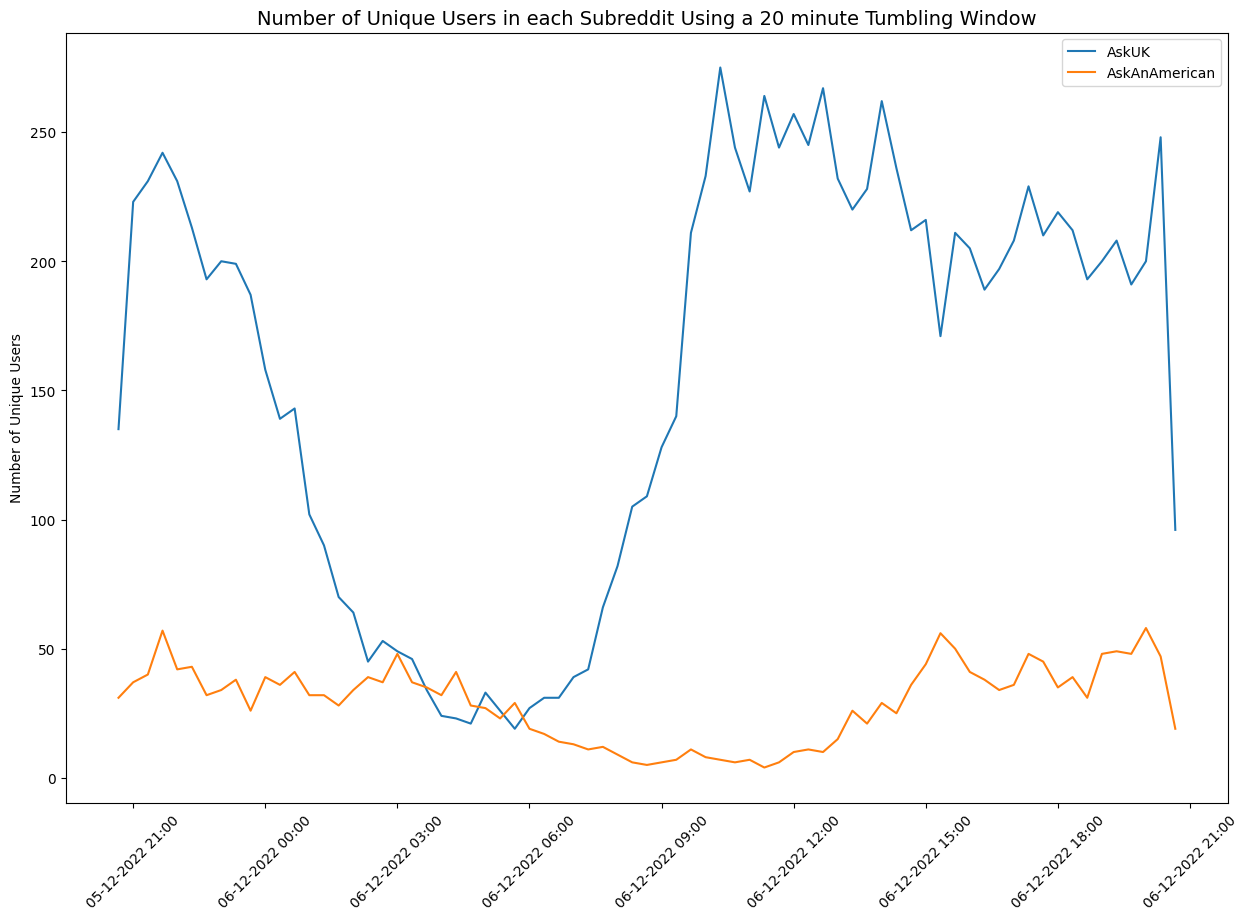

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(UK_cusers_tumb["time"], UK_cusers_tumb["count"], label = "AskUK")
ax.plot(US_cusers_tumb["time"], US_cusers_tumb["count"], label = "AskAnAmerican")
ax.set_title("Number of Unique Users in each Subreddit Using a 20 minute Tumbling Window", fontsize = 14)
plt.legend()
myFmt = mdates.DateFormatter('%d-%m-%Y %H:%M')
ax.set_ylabel("Number of Unique Users")
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

##### ii) Using a hopping window

For both datasets, create our hopping window objects of length 20 minutes and with a hop size of 5 minutes and then obtain the unique amount of users for each window.

In [16]:
UK_w0_hop = window('created_utc', "20 minute", "5 minute")
UK_cusers_hop = UK_data.groupBy(UK_w0_hop).agg(countDistinct('author')).sort('window').toPandas()

In [17]:
US_w0_hop = window('created_utc', "20 minute", "5 minute")
US_cusers_hop = US_data.groupBy(US_w0_hop).agg(countDistinct('author')).sort('window').toPandas()

In [18]:
UK_cusers_hop['time'] = UK_cusers_hop['window'].apply(lambda row: row[0])
UK_cusers_hop.rename(columns={'count(author)':'count'},inplace=True)

Our AskUk subreddit unique users counts and the corresponding windows. The time column represents the start time of the window.

In [19]:
UK_cusers_hop.head()

,window,count,time
0,"(2022-12-05 20:30:00, 2022-12-05 20:50:00)",31,2022-12-05 20:30:00
1,"(2022-12-05 20:35:00, 2022-12-05 20:55:00)",81,2022-12-05 20:35:00
2,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",135,2022-12-05 20:40:00
3,"(2022-12-05 20:45:00, 2022-12-05 21:05:00)",194,2022-12-05 20:45:00
4,"(2022-12-05 20:50:00, 2022-12-05 21:10:00)",221,2022-12-05 20:50:00


In [20]:
US_cusers_hop['time'] = US_cusers_hop['window'].apply(lambda row: row[0])
US_cusers_hop.rename(columns={'count(author)':'count'},inplace=True)

Our AskAnAmerican subreddit unique users counts and the corresponding windows. 

In [21]:
US_cusers_hop.head()

,window,count,time
0,"(2022-12-05 20:30:00, 2022-12-05 20:50:00)",9,2022-12-05 20:30:00
1,"(2022-12-05 20:35:00, 2022-12-05 20:55:00)",21,2022-12-05 20:35:00
2,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",31,2022-12-05 20:40:00
3,"(2022-12-05 20:45:00, 2022-12-05 21:05:00)",38,2022-12-05 20:45:00
4,"(2022-12-05 20:50:00, 2022-12-05 21:10:00)",41,2022-12-05 20:50:00


Plot of the number of unique users in each subreddit using a hopping window of length 20 minutes and a 5 minutes hop size.

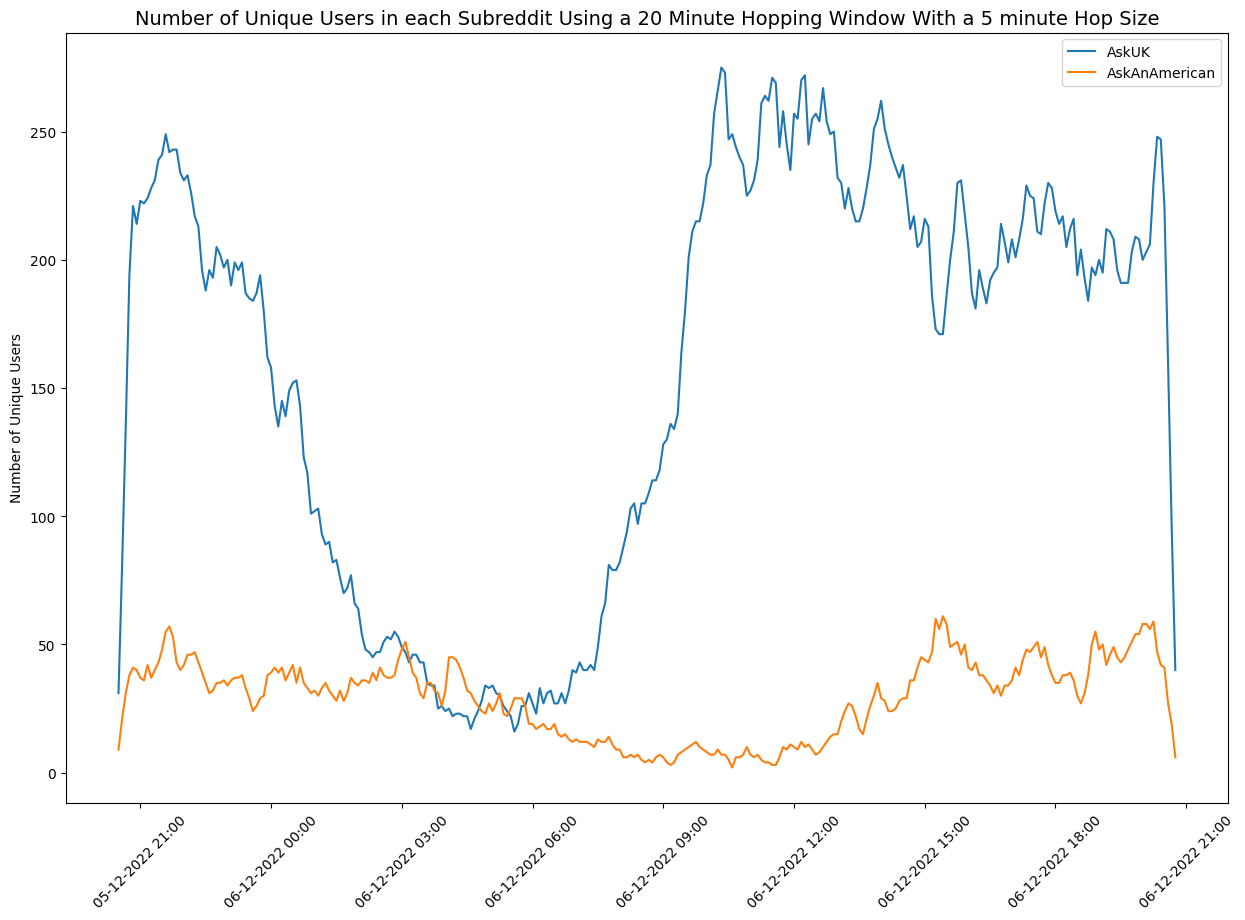

In [22]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(UK_cusers_hop["time"], UK_cusers_hop["count"], label = "AskUK")
ax.plot(US_cusers_hop["time"], US_cusers_hop["count"], label = "AskAnAmerican")
ax.set_title("Number of Unique Users in each Subreddit Using a 20 Minute Hopping Window With a 5 minute Hop Size", fontsize = 14)
plt.legend()
ax.set_ylabel("Number of Unique Users")
myFmt = mdates.DateFormatter('%d-%m-%Y %H:%M')
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

Both plots indicate that over the course of the 24 hours that this data was collected, there were a lot lot more unique users in the AskUK subreddit (with a peak around 260) than there are in the AskAnAmerican subreddit (a peak around 55), at mostly all times of the day. This therefore indicates that the AskUK subreddit was the more popular subreddit over that time period. 

Furthermore, this plot also shows that the number of unique users in the AskUK subreddit greatly decreased from around 9pm to 6am the next day before starting to  increase again, with the amount of unique users in the subreddit being around the same amount as the AskAnAmerican subreddit. This is to be expected because many people in the UK will be asleep between that time period and therefore it makes sense to see a decrease in the number of unique users in a subreddit dedicated to the UK. 

Although not as drastic as for the AskUk subreddit, the AskAnAmerican subreddit also sees a decrease in the amount of unique users, but between around 4am until 10am before slowly increasing again. This can be analysed in the same way as for the AskUK subreddit, however, because the time zone is different in the US than in the UK, this will be reflected in the UTC time in which the decrease happens, which is indeed the case.

#### Average number of words per comment for each subreddit

##### i) Using a tumbling window

For both datasets, create our tumbling window objects of length 20 minutes and then obtain the average words per comment for each window.

In [23]:
UK_w0_tumb = window('created_utc', "20 minute")
UK_musers_tumb = UK_data.groupBy(UK_w0_tumb).agg(mean(size(split("body", pattern = " ")))).sort('window').toPandas()

In [24]:
US_w0_tumb = window('created_utc', "20 minute")
US_musers_tumb = US_data.groupBy(US_w0_tumb).agg(mean(size(split("body", pattern = " ")))).sort('window').toPandas()

In [25]:
UK_musers_tumb['time'] = UK_musers_tumb['window'].apply(lambda row: row[0])
UK_musers_tumb.rename(columns={'avg(size(split(body,  , -1)))':'mean'},inplace=True)

Our AskUk subreddit average words per comment and the corresponding windows. The time column represents the start time of the window.

In [26]:
UK_musers_tumb.head()

,window,mean,time
0,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",30.552632,2022-12-05 20:40:00
1,"(2022-12-05 21:00:00, 2022-12-05 21:20:00)",30.928082,2022-12-05 21:00:00
2,"(2022-12-05 21:20:00, 2022-12-05 21:40:00)",28.564356,2022-12-05 21:20:00
3,"(2022-12-05 21:40:00, 2022-12-05 22:00:00)",26.584375,2022-12-05 21:40:00
4,"(2022-12-05 22:00:00, 2022-12-05 22:20:00)",30.882540,2022-12-05 22:00:00


In [27]:
US_musers_tumb['time'] = US_musers_tumb['window'].apply(lambda row: row[0])
US_musers_tumb.rename(columns={'avg(size(split(body,  , -1)))':'mean'},inplace=True)

Our AskAnAmerican subreddit average words per comment and the corresponding windows.

In [28]:
US_musers_tumb.head()

,window,mean,time
0,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",21.600000,2022-12-05 20:40:00
1,"(2022-12-05 21:00:00, 2022-12-05 21:20:00)",47.695652,2022-12-05 21:00:00
2,"(2022-12-05 21:20:00, 2022-12-05 21:40:00)",38.075472,2022-12-05 21:20:00
3,"(2022-12-05 21:40:00, 2022-12-05 22:00:00)",25.089744,2022-12-05 21:40:00
4,"(2022-12-05 22:00:00, 2022-12-05 22:20:00)",49.584906,2022-12-05 22:00:00


Plot of the average amount of words per comment in each subreddit using a 20 minute tumbling window.

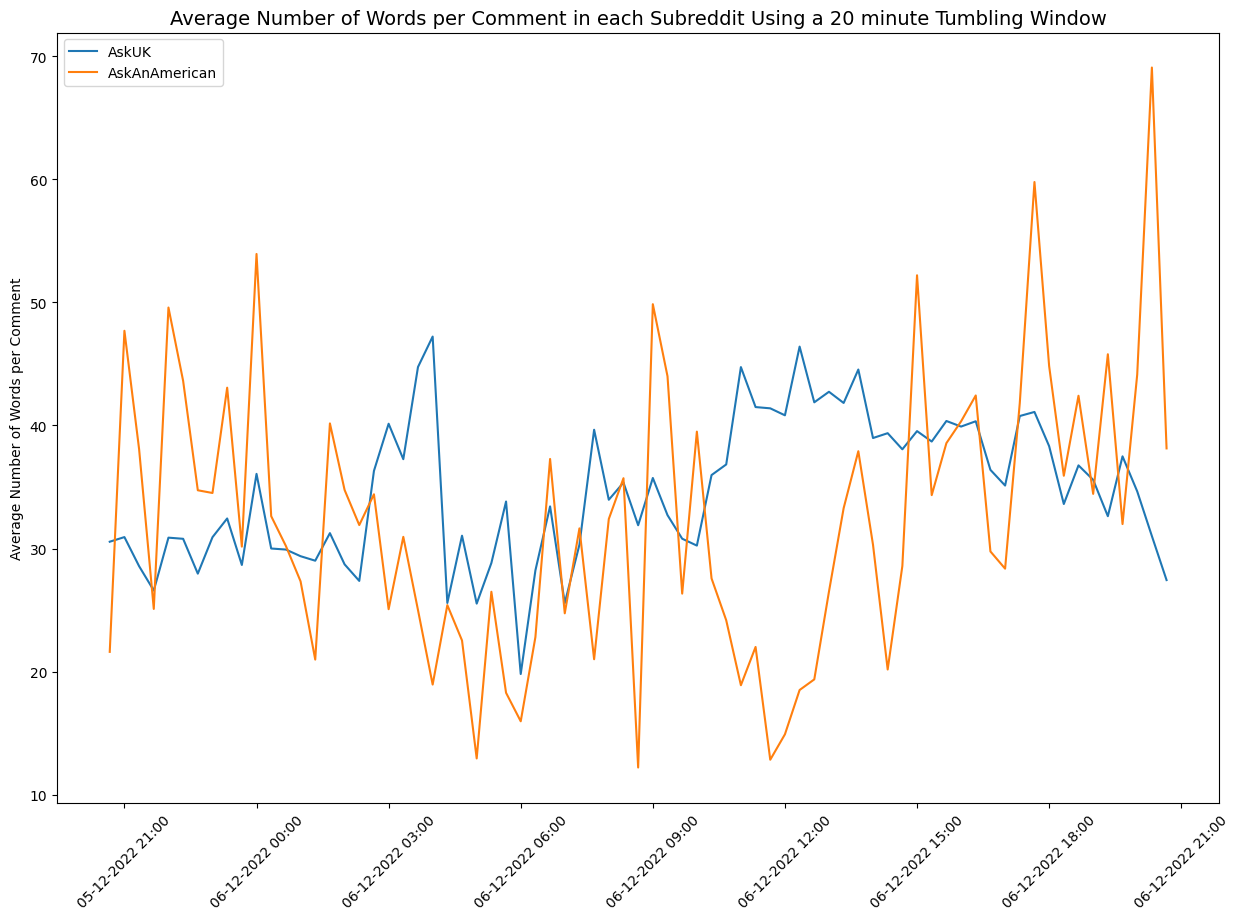

In [29]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(UK_musers_tumb["time"], UK_musers_tumb["mean"], label = "AskUK")
ax.plot(US_musers_tumb["time"], US_musers_tumb["mean"], label = "AskAnAmerican")
ax.set_title("Average Number of Words per Comment in each Subreddit Using a 20 minute Tumbling Window", fontsize = 14)
plt.legend()
myFmt = mdates.DateFormatter('%d-%m-%Y %H:%M')
ax.set_ylabel("Average Number of Words per Comment")
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

##### ii) Using a hopping window

For both datasets, create our hopping window objects of length 20 minutes and 5 minute hop size, then obtain the average words per comment for each window.

In [30]:
UK_w0_hop = window('created_utc', "20 minute", "5 minute")
UK_musers_hop = UK_data.groupBy(UK_w0_hop).agg(mean(size(split("body", pattern = " ")))).sort('window').toPandas()

In [31]:
US_w0_hop = window('created_utc', "20 minute", "5 minute")
US_musers_hop = US_data.groupBy(US_w0_hop).agg(mean(size(split("body", pattern = " ")))).sort('window').toPandas()

In [32]:
UK_musers_hop['time'] = UK_musers_hop['window'].apply(lambda row: row[0])
UK_musers_hop.rename(columns={'avg(size(split(body,  , -1)))':'mean'},inplace=True)

Our AskUk subreddit average words per comment and the corresponding windows. The time column represents the start time of the window.

In [33]:
UK_musers_hop.head()

,window,mean,time
0,"(2022-12-05 20:30:00, 2022-12-05 20:50:00)",34.129032,2022-12-05 20:30:00
1,"(2022-12-05 20:35:00, 2022-12-05 20:55:00)",29.988235,2022-12-05 20:35:00
2,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",30.552632,2022-12-05 20:40:00
3,"(2022-12-05 20:45:00, 2022-12-05 21:05:00)",30.146018,2022-12-05 20:45:00
4,"(2022-12-05 20:50:00, 2022-12-05 21:10:00)",31.891697,2022-12-05 20:50:00


In [34]:
US_musers_hop['time'] = US_musers_hop['window'].apply(lambda row: row[0])
US_musers_hop.rename(columns={'avg(size(split(body,  , -1)))':'mean'},inplace=True)

Our AskAnAmerican subreddit average words per comment and the corresponding windows. 

In [35]:
US_musers_hop.head()

,window,mean,time
0,"(2022-12-05 20:30:00, 2022-12-05 20:50:00)",18.222222,2022-12-05 20:30:00
1,"(2022-12-05 20:35:00, 2022-12-05 20:55:00)",21.458333,2022-12-05 20:35:00
2,"(2022-12-05 20:40:00, 2022-12-05 21:00:00)",21.600000,2022-12-05 20:40:00
3,"(2022-12-05 20:45:00, 2022-12-05 21:05:00)",24.830189,2022-12-05 20:45:00
4,"(2022-12-05 20:50:00, 2022-12-05 21:10:00)",31.054545,2022-12-05 20:50:00


Plot of the average amount of words per comment in each subreddit using a 20 minute hopping window with a 5 minute hop size.

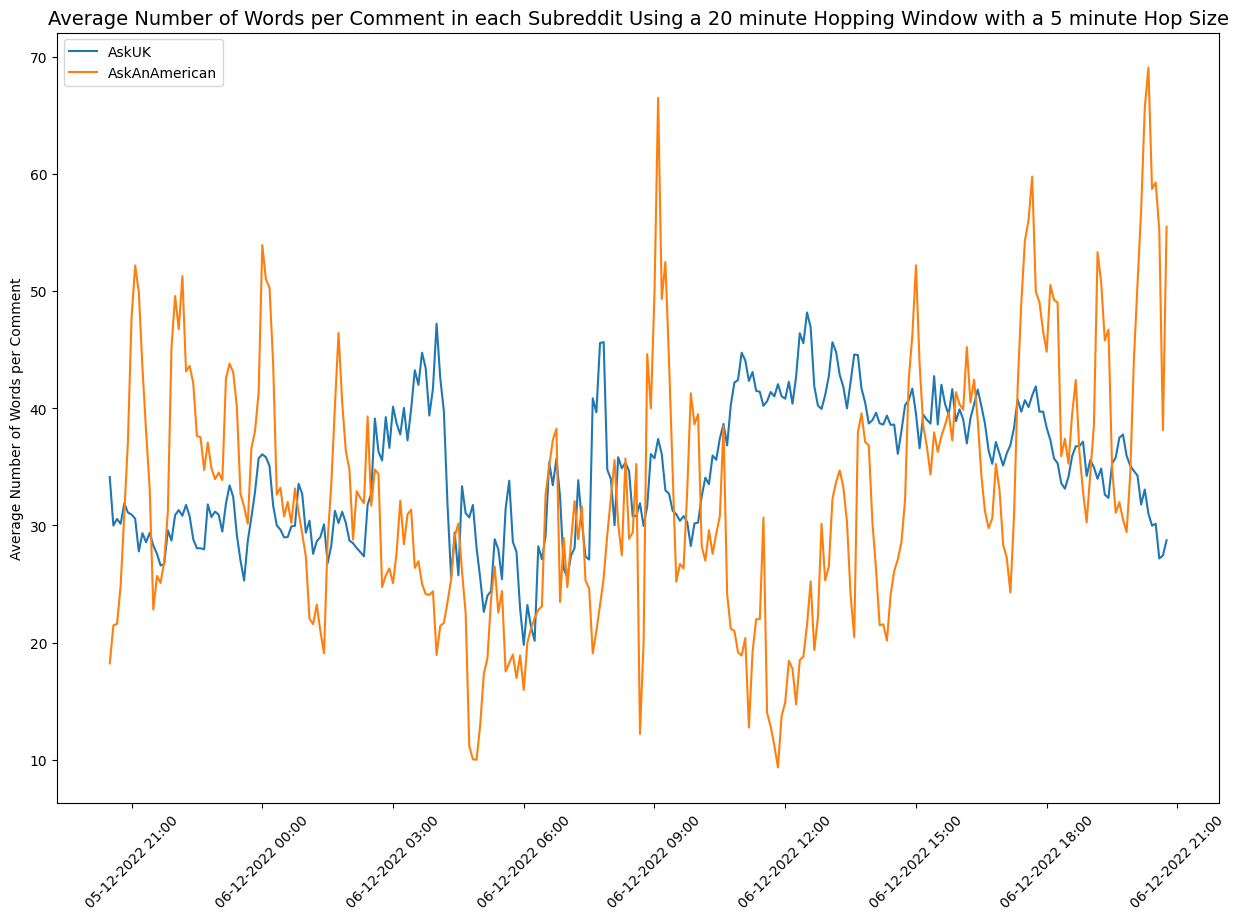

In [36]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(UK_musers_hop["time"], UK_musers_hop["mean"], label = "AskUK")
ax.plot(US_musers_hop["time"], US_musers_hop["mean"], label = "AskAnAmerican")
ax.set_title("Average Number of Words per Comment in each Subreddit Using a 20 minute Hopping Window with a 5 minute Hop Size", fontsize = 14)
plt.legend()
myFmt = mdates.DateFormatter('%d-%m-%Y %H:%M')
ax.set_ylabel("Average Number of Words per Comment")
ax.xaxis.set_major_formatter(myFmt)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

When comparing the two types of window used to calculate the average number of words per comment, we can see that both plots look quite alike in terms of their general pattern, they both seem to increase and decrease in the same time slots. The main difference between both plots is the variations. Indeed, using a hopping window gives a lot more datapoints than the tumbling window. This is visible in the plot because the plot for the hopping window is a lot more jagged than the plot obtained using a tumbling window, which is much smoother. 